# Import Libraries

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Decision Tree Model

In [ ]:
def decTreeRegressor(input_file):
    # Load and prepare data
    data = pd.read_csv(input_file)

    # Encode categorical target variable
    label_encoder = LabelEncoder()
    data['Glucose_Level_Range'] = label_encoder.fit_transform(data['Glucose_Level_Range'])

    # Feature/target split
    targets = ['Glucose_15min', 'Glucose_30min', 'Glucose_45min', 'Glucose_60min']
    X = data.drop(targets + ['Time'], axis=1)
    y = data[targets]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Define parameter grid for tuning
    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['log2', 'sqrt'],
        'criterion': ['squared_error', 'friedman_mse']
    }

    # Initialize and run GridSearchCV
    dtree = DecisionTreeRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=dtree,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Print best parameters
    print("\nBest Parameters:")
    print(grid_search.best_params_)

    # Evaluate on test set
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nOverall Test Set Evaluation:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")

    # Calculate ±25% error range accuracy for each time point
    print("\nTime-Specific Accuracy (±25%):")
    for i, target in enumerate(targets):
        lower = 0.75 * y_pred[:, i]
        upper = 1.25 * y_pred[:, i]
        accurate = np.sum((y_test[target].values >= lower) & (y_test[target].values <= upper))
        accuracy = accurate / len(y_pred) * 100
        print(f"{target}: {accuracy:.2f}% accurate")

    # Calculate overall ±25% accuracy
    accurate_predictions = np.all(
        (y_test.values >= 0.75 * y_pred) & (y_test.values <= 1.25 * y_pred),
        axis=1
    )
    overall_accuracy = np.mean(accurate_predictions) * 100
    print(f"\nOverall Accuracy (±25% range): {overall_accuracy:.2f}%")

    print('\n\n')
    
    # Visualise predictions with error patterns
    plt.figure(figsize=(18, 6))
    
    # Actual vs Predicted
    plt.subplot(1, 3, 1)
    target_idx = 0  # Glucose_15min
    plt.scatter(y_test.iloc[:, target_idx], y_pred[:, target_idx], 
               alpha=0.3, color='blue')
    plt.plot([y_test.min().min(), y_test.max().max()], 
             [y_test.min().min(), y_test.max().max()], 
             'r--', lw=1)
    plt.xlabel('Actual Glucose')
    plt.ylabel('Predicted Glucose')
    plt.title(f'Actual vs Predicted ({targets[target_idx]})')
    
    # Error Distribution
    plt.subplot(1, 3, 2)
    errors = y_test.values - y_pred
    plt.boxplot([errors[:, i] for i in range(4)], 
                labels=targets,
                showfliers=False)  # Remove outliers for cleaner visualisation
    plt.axhline(y=0, color='k', linestyle='--')
    plt.ylabel('Prediction Error (mmol/L)')
    plt.title('Error Distribution by Time Horizon')
    
    # Accuracy by Time Horizon
    plt.subplot(1, 3, 3)
    accuracies = []
    for i in range(4):
        lower = 0.75 * y_pred[:, i]
        upper = 1.25 * y_pred[:, i]
        acc = ((y_test.iloc[:, i] >= lower) & (y_test.iloc[:, i] <= upper)).mean() * 100
        accuracies.append(acc)
    
    plt.bar(targets, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylabel('Accuracy (%)')
    plt.title('±25% Accuracy by Time Horizon')
    plt.tight_layout()
    plt.show()
    
    print('\n\n')

    # Visualize the best tree
    plt.figure(figsize=(20, 10))
    plot_tree(
        best_model,
        filled=True,
        feature_names=X.columns,
        proportion=True,
        rounded=True,
        max_depth=3
    )
    plt.title("Optimized Decision Tree (First 3 Levels)")
    plt.show()

## T1D Data

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}

Overall Test Set Evaluation:
RMSE: 1.49
MAE: 1.04
R² Score: 0.83

Time-Specific Accuracy (±25%):
Glucose_15min: 97.56% accurate
Glucose_30min: 91.65% accurate
Glucose_45min: 84.79% accurate
Glucose_60min: 78.38% accurate

Overall Accuracy (±25% range): 75.45%





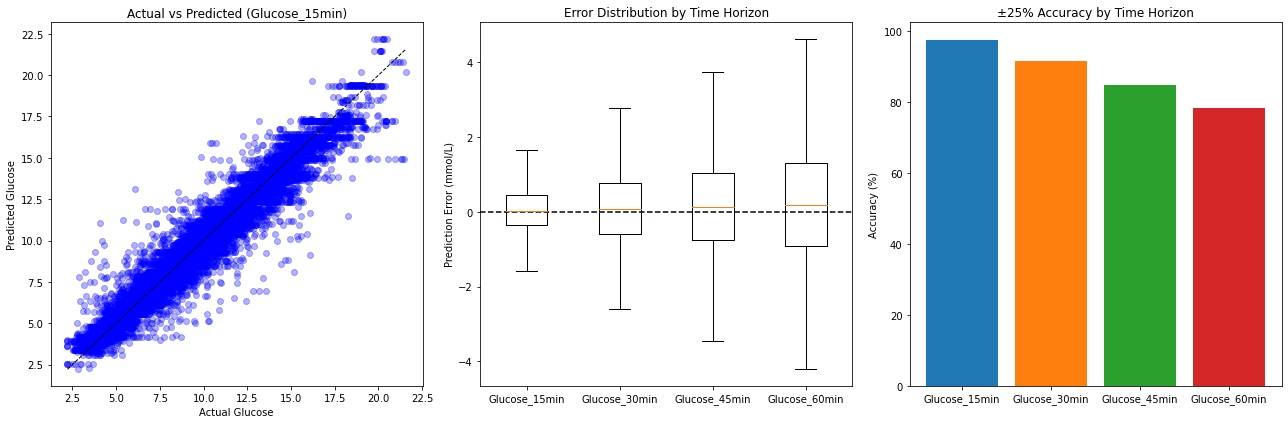

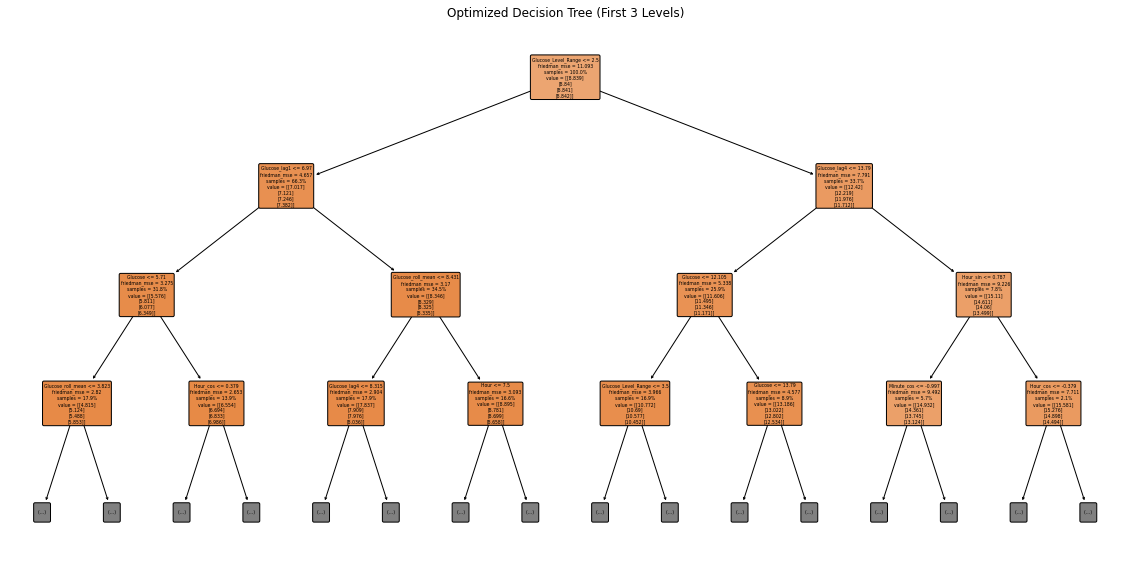

In [87]:
decTreeRegressor('Processed_Data/T1D_Data/combined_T1D_data.csv')

## T2D Data

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}

Overall Test Set Evaluation:
RMSE: 3.02
MAE: 1.74
R² Score: 0.75

Time-Specific Accuracy (±25%):
Glucose_15min: 95.00% accurate
Glucose_30min: 86.21% accurate
Glucose_45min: 76.26% accurate
Glucose_60min: 67.81% accurate

Overall Accuracy (±25% range): 65.66%





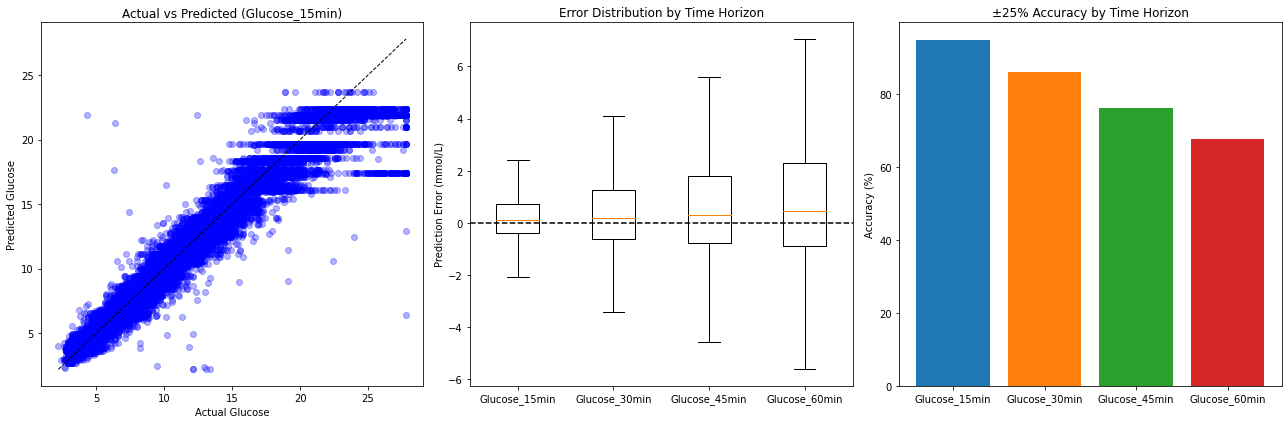

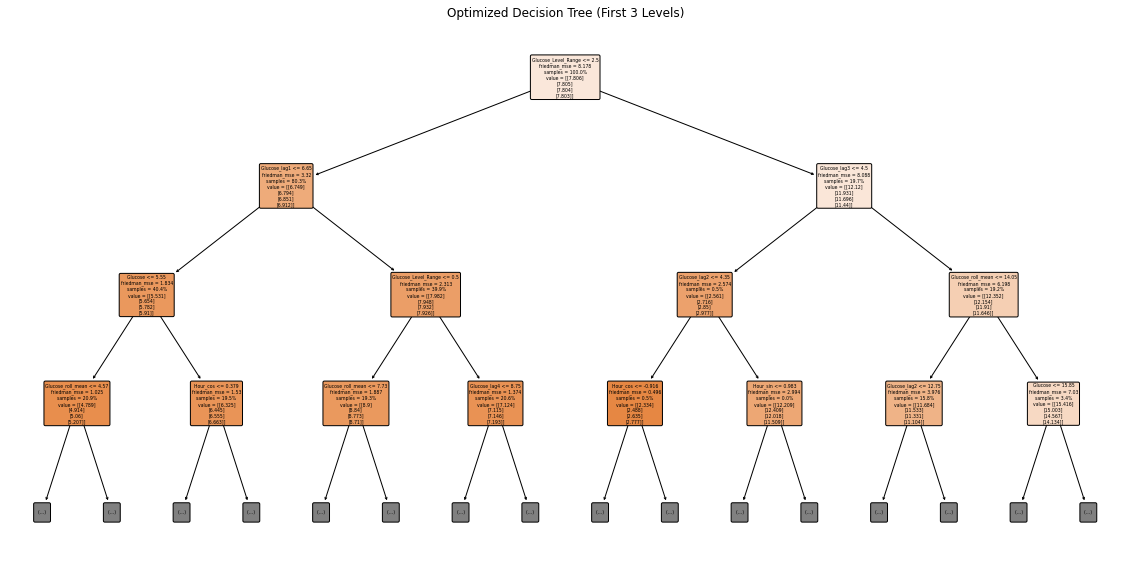

In [88]:
decTreeRegressor('Processed_Data/T2D_Data/combined_T2D_data.csv')

## Ohio Data Only

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}

Overall Test Set Evaluation:
RMSE: 1.49
MAE: 1.04
R² Score: 0.83

Time-Specific Accuracy (±25%):
Glucose_15min: 97.70% accurate
Glucose_30min: 91.97% accurate
Glucose_45min: 85.28% accurate
Glucose_60min: 78.02% accurate

Overall Accuracy (±25% range): 75.39%





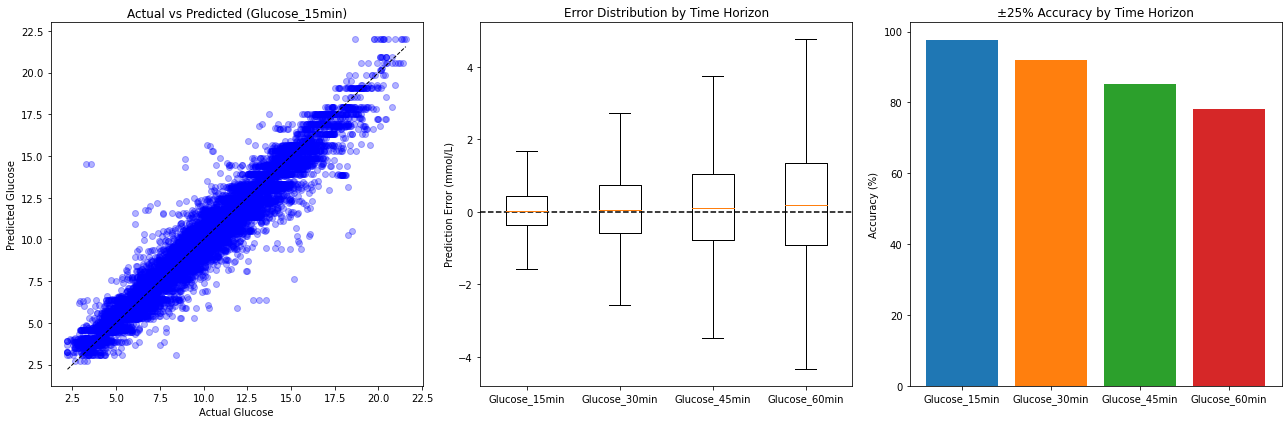

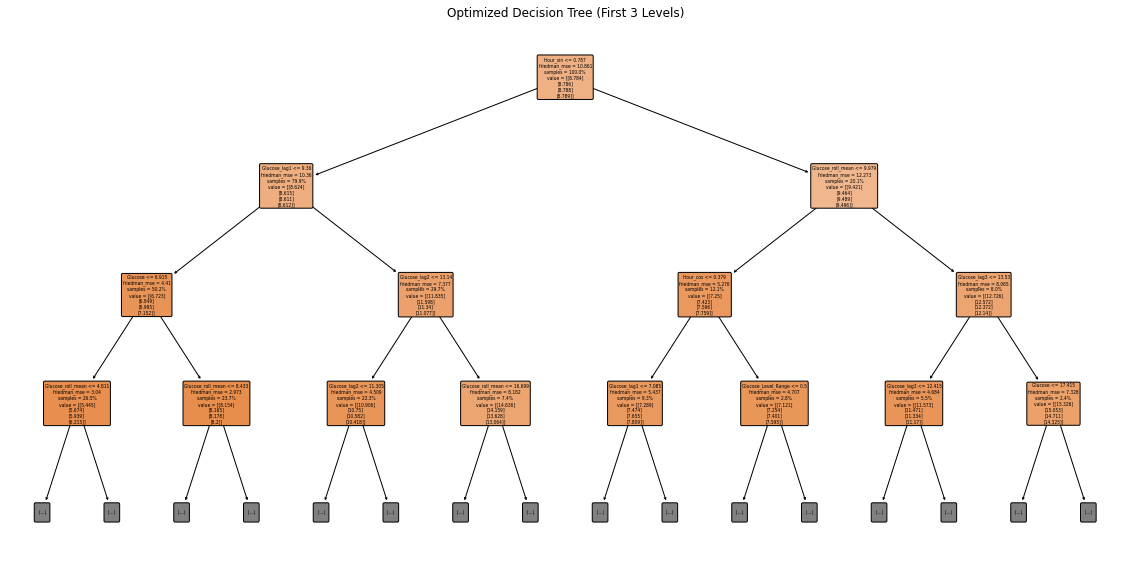

In [89]:
decTreeRegressor('Processed_Data/T1D_Data/combined_ohio_data.csv')

## Shanghai T1D Data Only

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10}

Overall Test Set Evaluation:
RMSE: 1.98
MAE: 1.39
R² Score: 0.71

Time-Specific Accuracy (±25%):
Glucose_15min: 92.74% accurate
Glucose_30min: 83.33% accurate
Glucose_45min: 73.81% accurate
Glucose_60min: 66.19% accurate

Overall Accuracy (±25% range): 62.62%





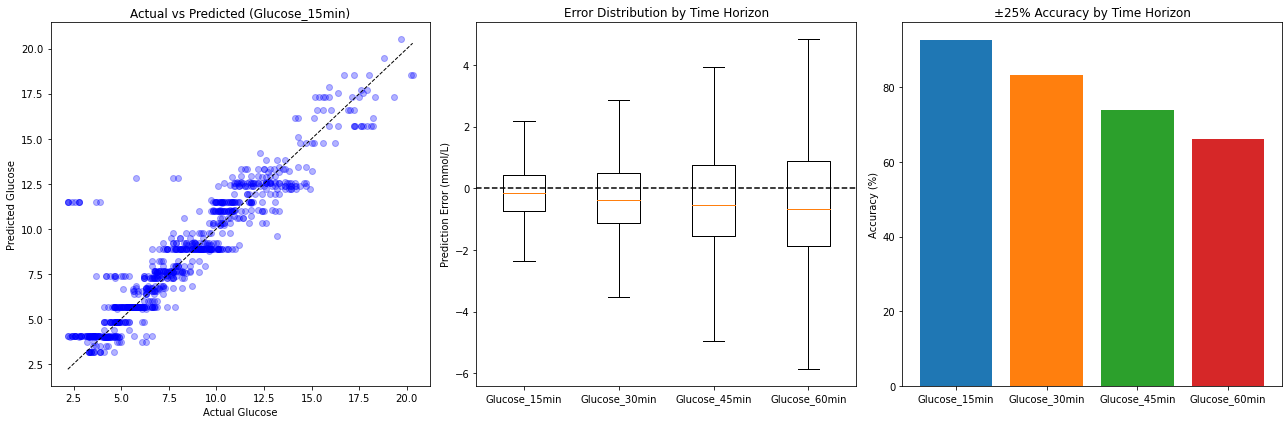

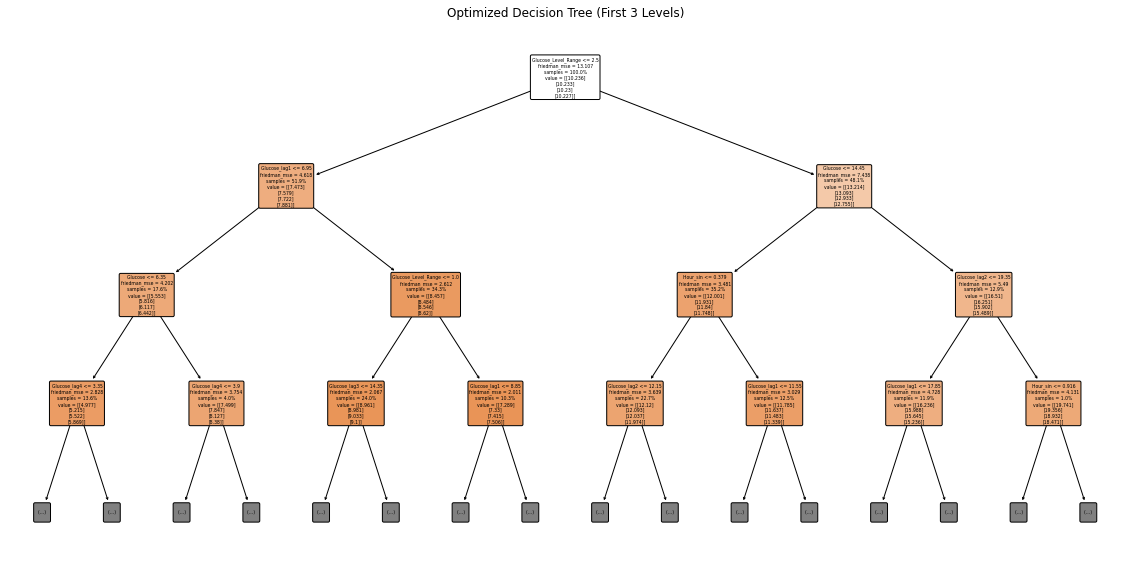

In [90]:
decTreeRegressor('Processed_Data/T1D_Data/combined_shanghait1d_data.csv')

## Shanghai T2D Data Only

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2}

Overall Test Set Evaluation:
RMSE: 1.18
MAE: 0.78
R² Score: 0.83

Time-Specific Accuracy (±25%):
Glucose_15min: 98.05% accurate
Glucose_30min: 92.63% accurate
Glucose_45min: 86.83% accurate
Glucose_60min: 82.01% accurate

Overall Accuracy (±25% range): 79.68%





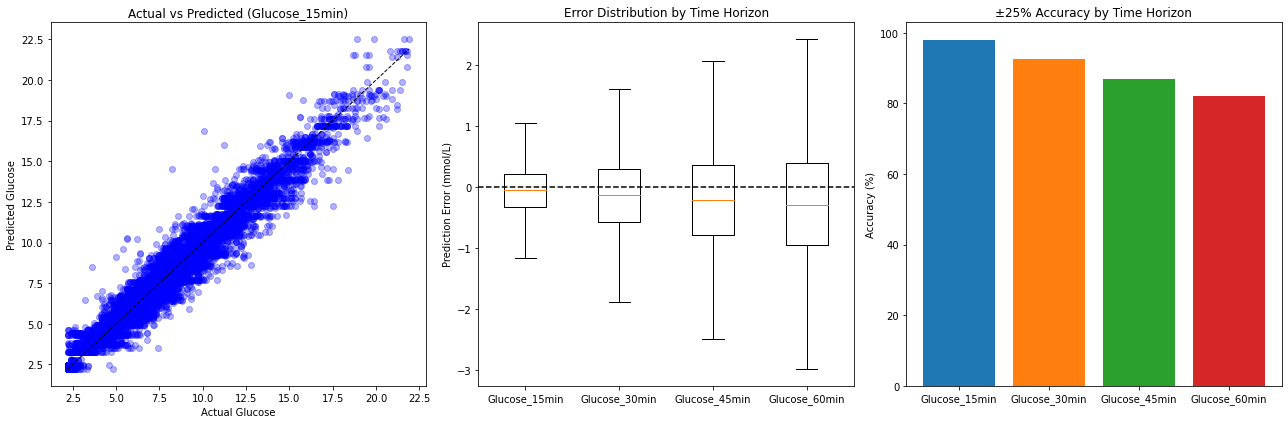

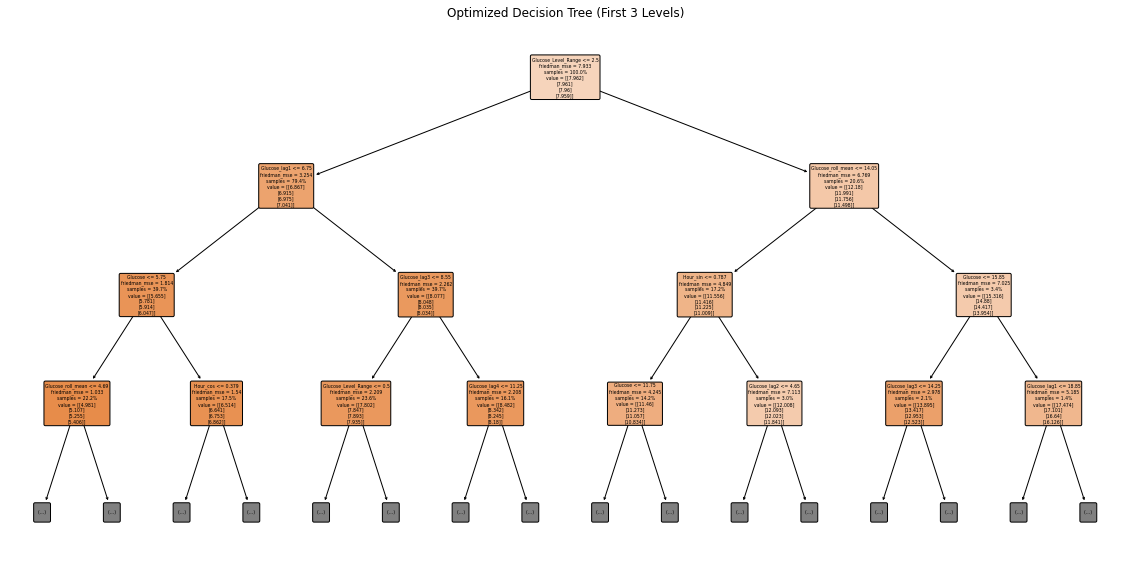

In [91]:
decTreeRegressor('Processed_Data/T2D_Data/combined_shanghait2d_data.csv')

## Participant Data Only

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\bob_s\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan      


Best Parameters:
{'criterion': 'friedman_mse', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}

Overall Test Set Evaluation:
RMSE: 2.49
MAE: 1.78
R² Score: 0.84

Time-Specific Accuracy (±25%):
Glucose_15min: 98.25% accurate
Glucose_30min: 94.32% accurate
Glucose_45min: 87.82% accurate
Glucose_60min: 80.90% accurate

Overall Accuracy (±25% range): 80.18%





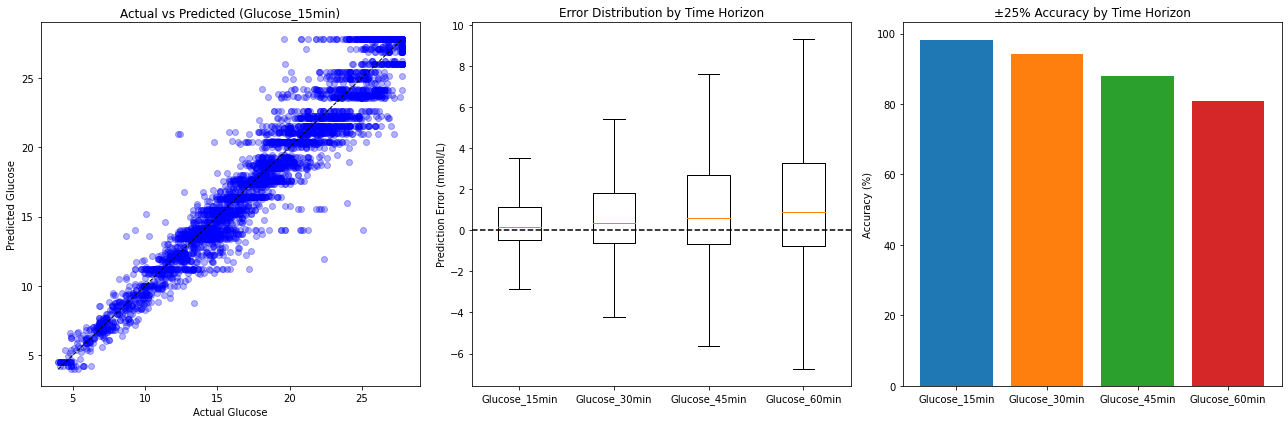

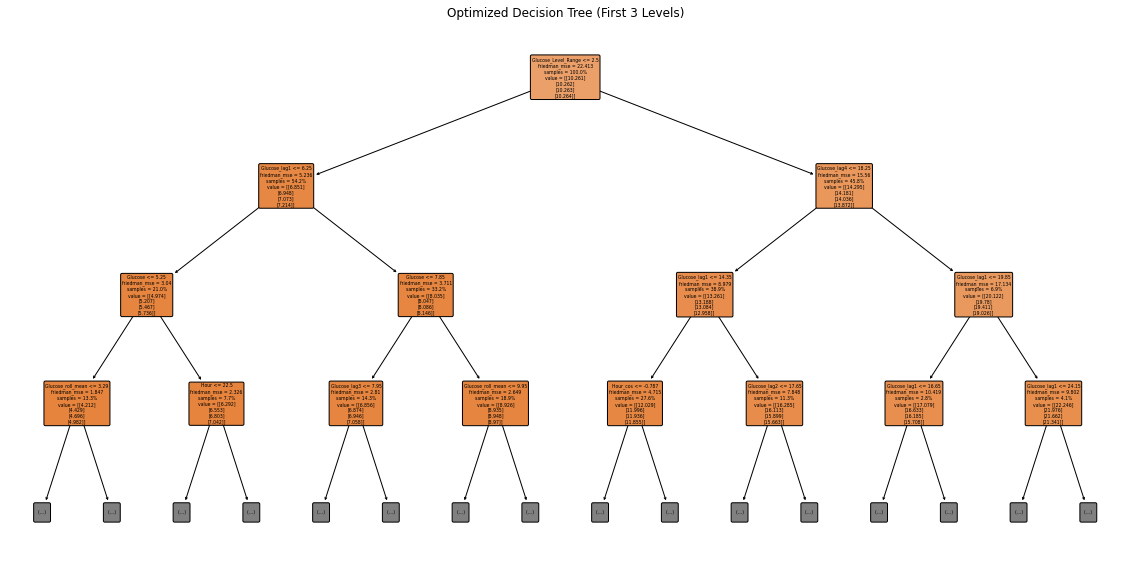

In [92]:
decTreeRegressor('Processed_Data/T2D_Data/participant_data_processed.csv')